In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
#import sklearn
#from sklearn.model_selection import train_test_split

In [2]:
tf.version.VERSION

'2.9.2'

In [2]:
os.getcwd()

'/data/private/Thesis/May'

In [10]:
train_x = np.load('Data/03_Patch/train/x1.npy')
train_y = np.load('Data/03_Patch/train/y.npy')
val_x = np.load('Data/03_Patch/val/x1.npy')
val_y = np.load('Data/03_Patch/val/y.npy')

print(train_x.shape)
print(val_x.shape)
print(train_y.shape)
print(val_y.shape)

(1058, 256, 256, 2)
(529, 256, 256, 2)
(1058, 256, 256, 1)
(529, 256, 256, 1)


In [11]:
train_y[np.where( train_y < 1 )] = 0
labels, count = np.unique(train_y[:,:,0], return_counts=True)
print("Training labels are: ", labels, " and the counts are: ", count)

Training labels are:  [0. 1.]  and the counts are:  [ 75386 195462]


In [7]:
val_y[np.where( val_y < 1 )] = 0
labels, count = np.unique(val_y[:,:,0], return_counts=True)
print("Validation labels are: ", labels, " and the counts are: ", count)

Validation labels are:  [0. 1.]  and the counts are:  [72066 63358]


In [8]:
print(train_y.shape)
print(val_y.shape)

(1058, 256, 256, 1)
(529, 256, 256, 1)


In [12]:
# 1hot for label datasets
train_y = tf.keras.utils.to_categorical(train_y)
val_y = tf.keras.utils.to_categorical(val_y)

print(train_y.shape)
print(val_y.shape)

IndexError: index -9999 is out of bounds for axis 1 with size 2

### **Build Networks**

In [13]:
def unet(patch_size, n_bands, n_classes):
    inputs = tf.keras.Input(shape=(patch_size, patch_size, n_bands))
    
    # ENCODER
    conv1 = tf.keras.layers.Conv2D(64, 3, padding='same')(inputs)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = tf.keras.layers.ReLU()(conv1)
    conv1 = tf.keras.layers.Conv2D(64, 3, padding='same')(conv1)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = tf.keras.layers.ReLU()(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, padding='same')(pool1)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = tf.keras.layers.ReLU()(conv2)
    conv2 = tf.keras.layers.Conv2D(128, 3, padding='same')(conv2)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = tf.keras.layers.ReLU()(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = tf.keras.layers.Conv2D(256, 3, padding='same')(pool2)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.ReLU()(conv3)
    conv3 = tf.keras.layers.Conv2D(256, 3, padding='same')(conv3)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.ReLU()(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv3)

    # BOTTOM
    conv4 = tf.keras.layers.Conv2D(512, 3, padding='same')(pool3)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    conv4 = tf.keras.layers.ReLU()(conv4)
    conv4 = tf.keras.layers.Conv2D(512, 3, padding='same')(conv4)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    conv4 = tf.keras.layers.ReLU()(conv4)
    
    # DECODER
    # BN_Conv2DTranspose_ReLU: Biswas. #Upsampling2D_Conv2DTranspose_BN_ReLU: Chibber. #Upsamling2D_CONV_BN_ReLU: Practical
    # deconv = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides)

    deconv3 = tf.keras.layers.Conv2DTranspose(256, 3, strides=(2,2), padding='same')(conv4)
    merge3 = tf.keras.layers.concatenate([conv3, deconv3])
    uconv3 = tf.keras.layers.BatchNormalization()(merge3)
    uconv3 = tf.keras.layers.ReLU()(uconv3)
    uconv3 = tf.keras.layers.Conv2D(256, 3, padding='same')(uconv3)
    uconv3 = tf.keras.layers.BatchNormalization()(uconv3)
    uconv3 = tf.keras.layers.ReLU()(uconv3)
    uconv3 = tf.keras.layers.Conv2D(256, 3, padding='same')(uconv3)
    uconv3 = tf.keras.layers.BatchNormalization()(uconv3)
    uconv3 = tf.keras.layers.ReLU()(uconv3)

    deconv2 = tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same')(uconv3)
    merge2 = tf.keras.layers.concatenate([conv2, deconv2])
    uconv2 = tf.keras.layers.BatchNormalization()(merge2)
    uconv2 = tf.keras.layers.ReLU()(uconv2)
    uconv2 = tf.keras.layers.Conv2D(128, 3, padding='same')(uconv2)
    uconv2 = tf.keras.layers.BatchNormalization()(uconv2)
    uconv2 = tf.keras.layers.ReLU()(uconv2)
    uconv2 = tf.keras.layers.Conv2D(128, 3, padding='same')(uconv2)
    uconv2 = tf.keras.layers.BatchNormalization()(uconv2)
    uconv2 = tf.keras.layers.ReLU()(uconv2)

    deconv1 = tf.keras.layers.Conv2DTranspose(64, 3, strides=(2,2), padding='same')(uconv2)
    merge1 = tf.keras.layers.concatenate([conv1, deconv1])
    uconv1 = tf.keras.layers.BatchNormalization()(merge1)
    uconv1 = tf.keras.layers.ReLU()(uconv1)
    uconv1 = tf.keras.layers.Conv2D(64, 3, padding='same')(uconv1)
    uconv1 = tf.keras.layers.BatchNormalization()(uconv1)
    uconv1 = tf.keras.layers.ReLU()(uconv1)
    uconv1 = tf.keras.layers.Conv2D(64, 3, padding='same')(uconv1)
    uconv1 = tf.keras.layers.BatchNormalization()(uconv1)
    uconv1 = tf.keras.layers.ReLU()(uconv1)

    outputs = tf.keras.layers.Conv2D(n_classes, 1, activation="sigmoid")(uconv1)
    
    return tf.keras.Model(inputs, outputs)

In [14]:
# define parameters
PATCH_SIZE = 256
N_BANDS = 2
N_CLASSES = 2 #0: Backkground, 1: Oil palm
BATCH_SIZE = 10
EPOCHS = 50

In [15]:
model = unet(PATCH_SIZE, N_BANDS, N_CLASSES)

learning_rate=5e-6
decay_rate=1e-10#learning_rate / EPOCHS

# Compile as any Tensorflow model
model.compile(loss="binary_crossentropy", #binary_crossentropy,->for binary with n_class=1, background=NoData/Null
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])
              
model.summary()

2023-05-29 11:32:22.922571: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1216        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [17]:
pip install visualkeras

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 kB 3.9 MB/s eta 0:00:0000:01
--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1305, in render
    for render_output in iter_render:
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/segment.py", line 249, in split_lines
    for segment in segments:
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening '/tmp/tmphq8iv0aj.PNG'
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening '/tmp/tmp6bbbkk7r.PNG'


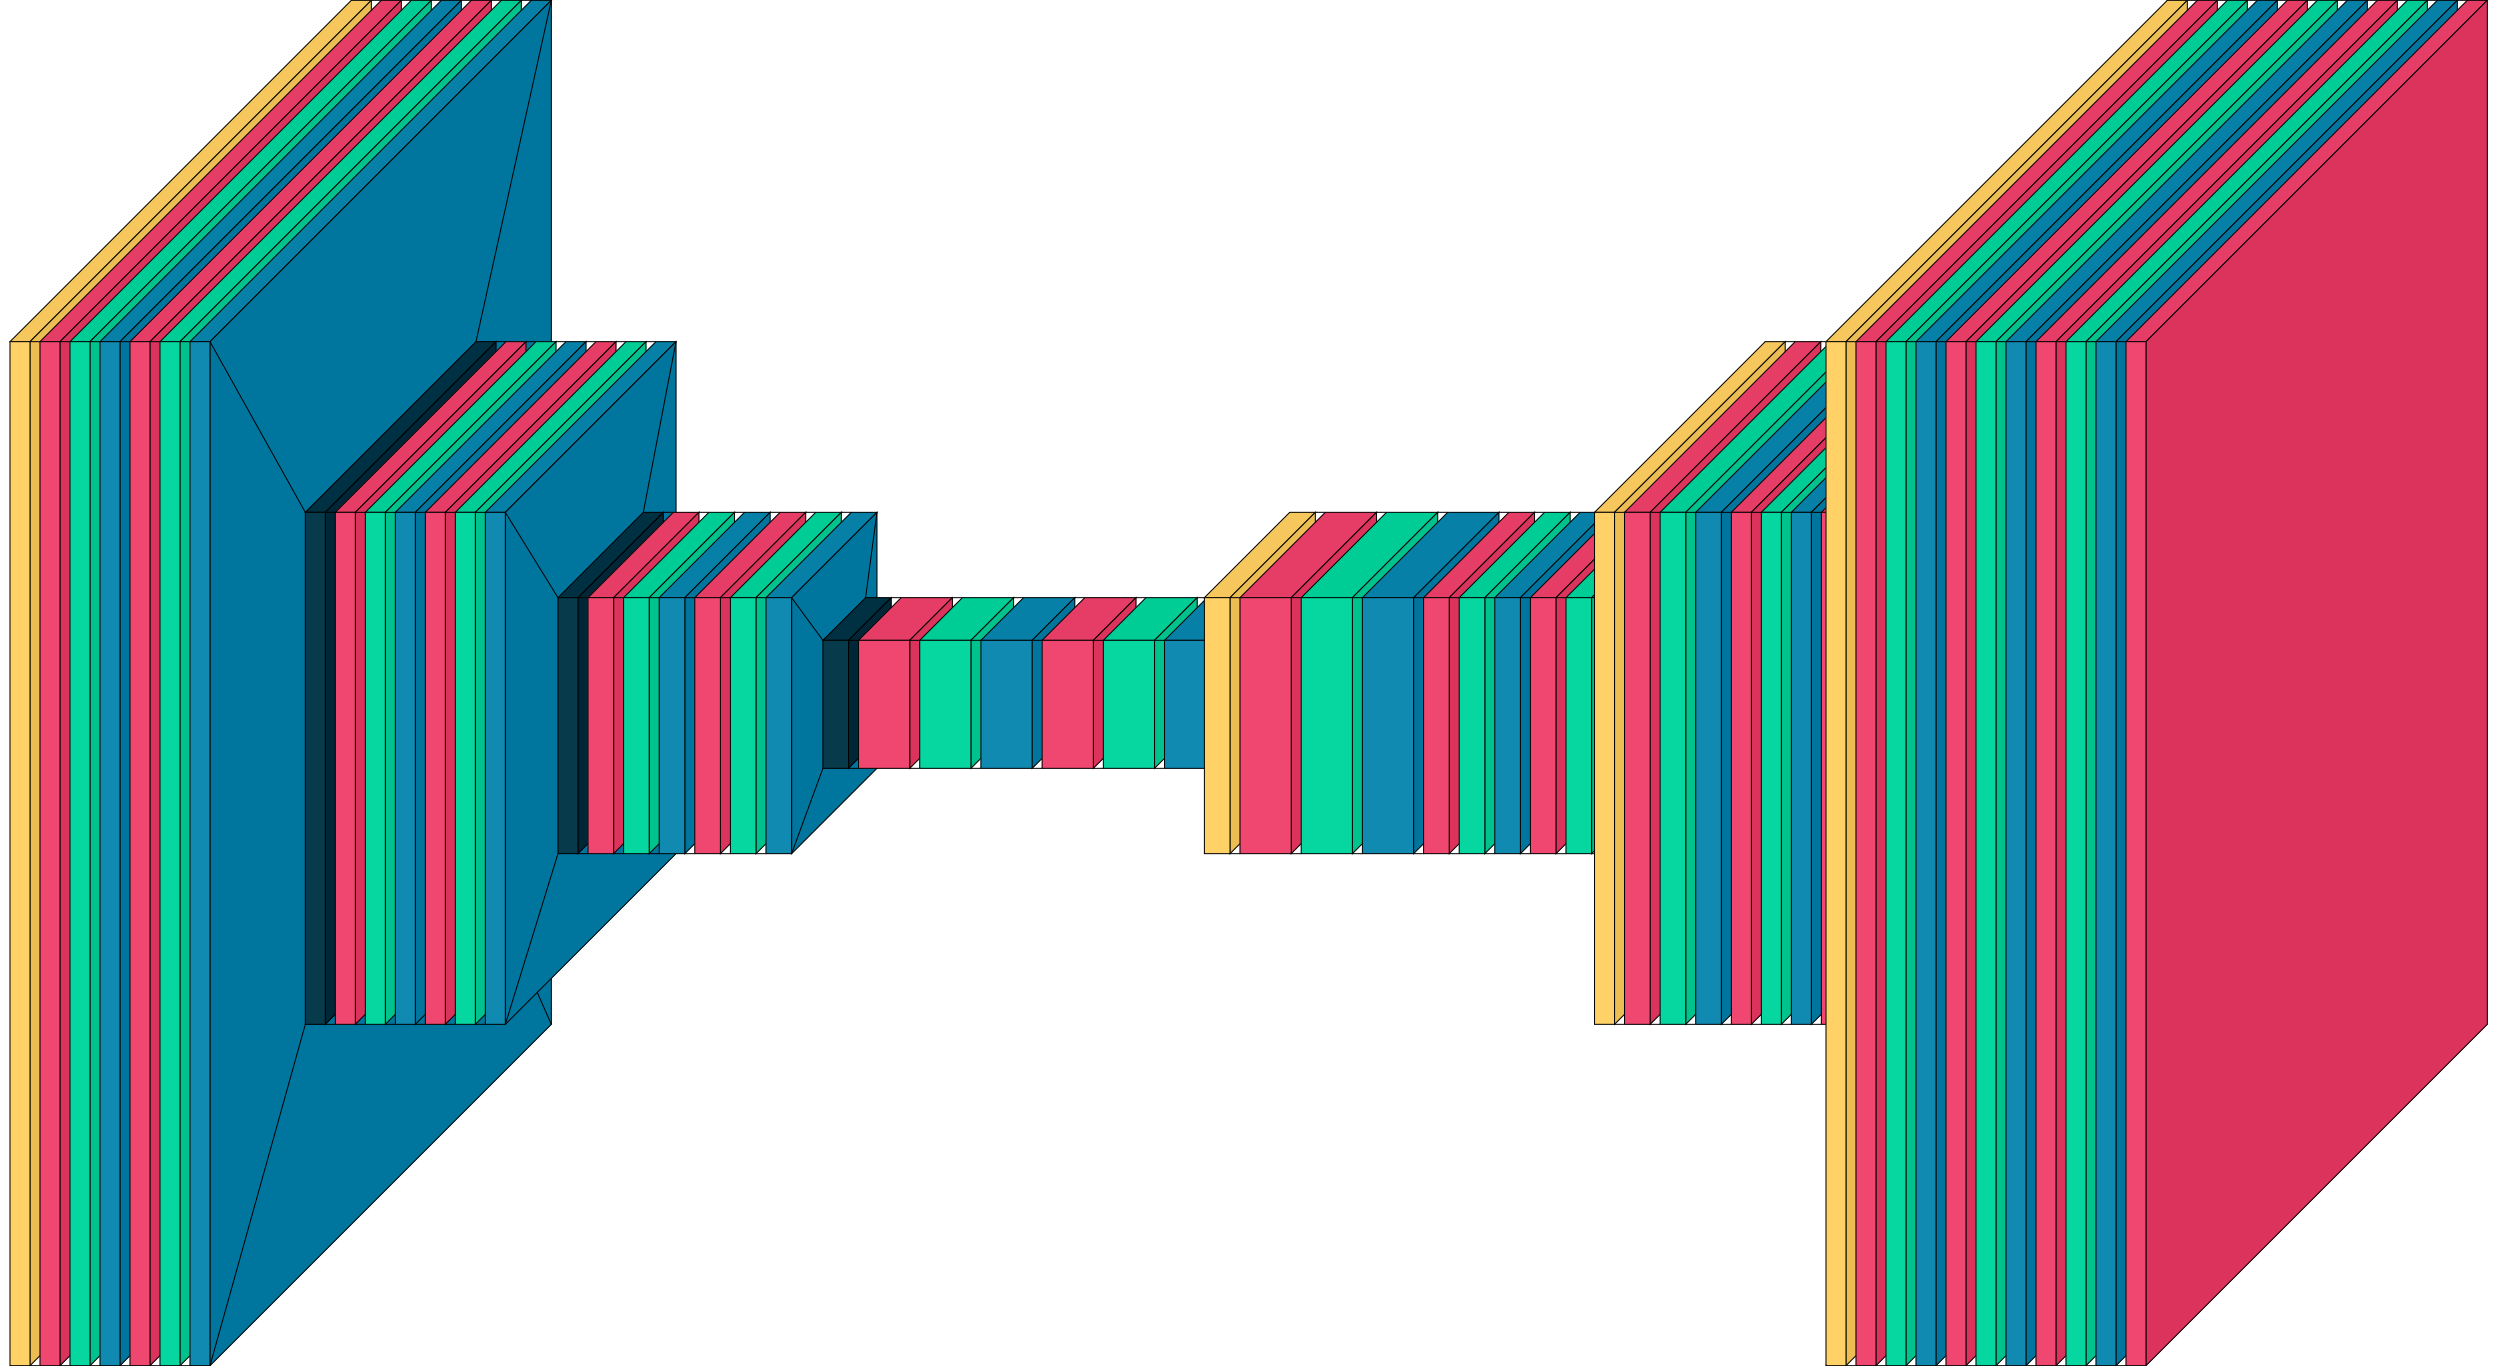

In [19]:
import visualkeras

model = model

visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, legend=True, to_file='output.png') # write to disk
visualkeras.layered_view(model, legend=True, to_file='output.png').show() # write and show

visualkeras.layered_view(model)

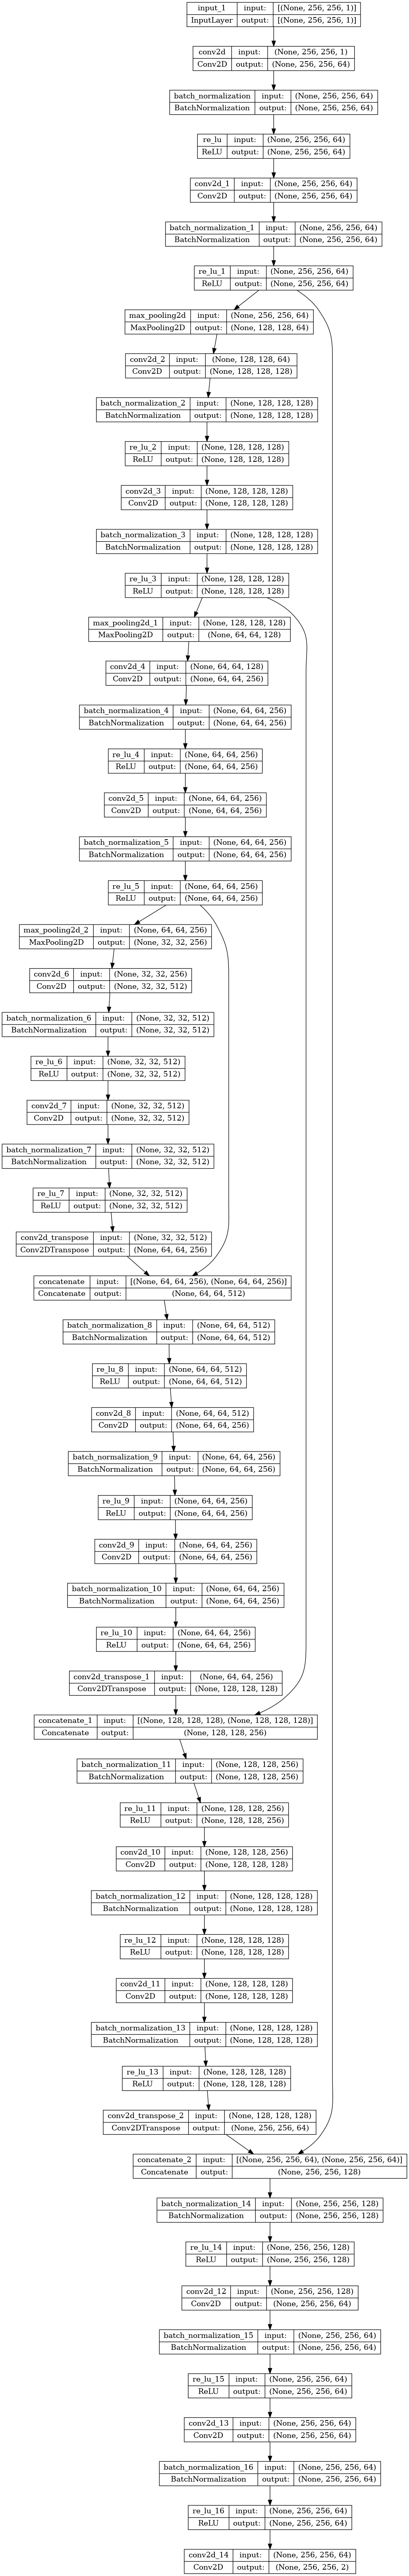

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True)

### **Training**

In [12]:
from IPython.display import clear_output

class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [13]:
conditions= [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath='Model/s1_m_1e-5/model.{epoch:02d}--{val_loss:.2f}.h5', save_best_only=True)]

In [14]:
callbacks_list = [PlotLearning(), conditions]

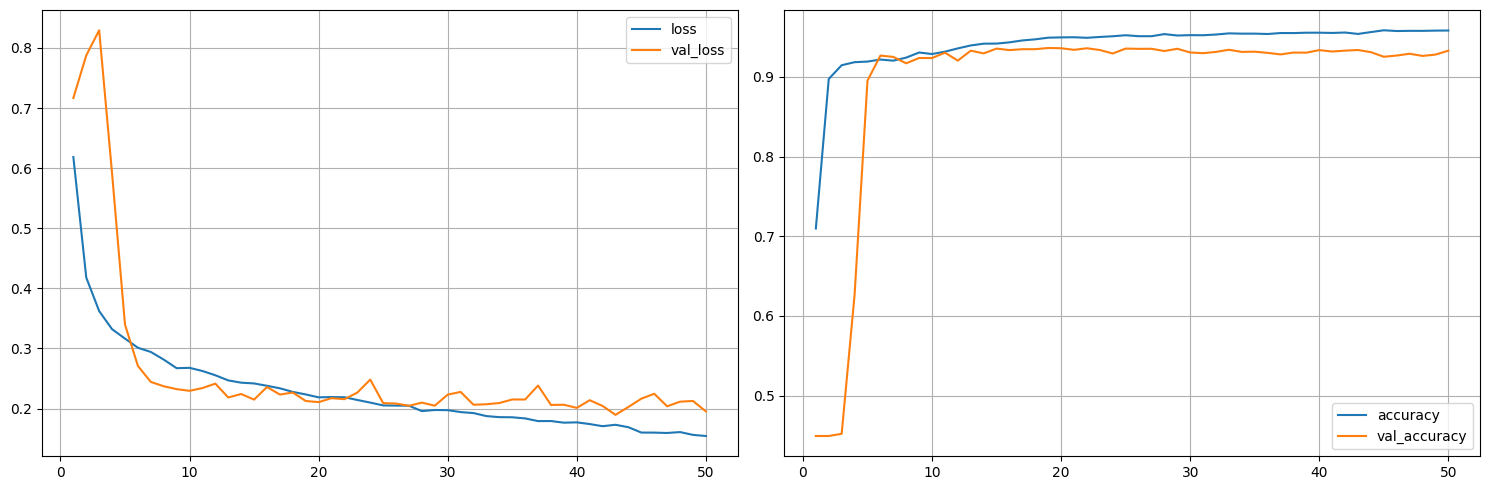

106/106 [==============================] - 30s 281ms/step - loss: 0.1544 - accuracy: 0.9581 - val_loss: 0.1953 - val_accuracy: 0.9328


In [13]:
history = model.fit(train_x, train_y, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(val_x, val_y), callbacks=callbacks_list, verbose=1)

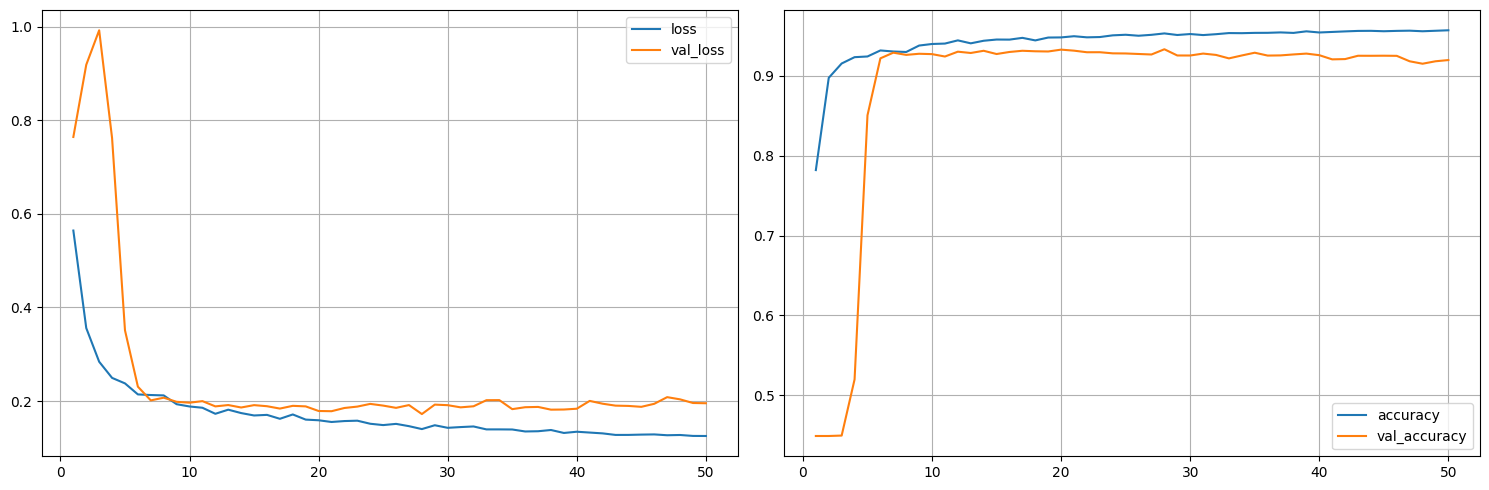

106/106 [==============================] - 29s 277ms/step - loss: 0.1253 - accuracy: 0.9567 - val_loss: 0.1953 - val_accuracy: 0.9195


In [15]:
history = model.fit(train_x, train_y, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(val_x, val_y), callbacks=callbacks_list, verbose=1)

In [15]:
model = tf.keras.models.load_model("Model/s1_m_1e-5/model.43--0.19.h5")

In [16]:
val_loss, val_acc = model.evaluate(val_x, val_y, batch_size=10) #1e-6
print(f"\nValidation accuracy: {100 * val_acc:.2f}%")

53/53 [==============================] - 4s 72ms/step - loss: 0.1896 - accuracy: 0.9337

Validation accuracy: 93.37%


In [17]:
model = tf.keras.models.load_model("Model/s1_m_1e-5/model.28--0.17.h5")

In [ ]:
val_loss, val_acc = model.evaluate(val_x, val_y, batch_size=10) #5e-6
print(f"\nValidation accuracy: {100 * val_acc:.2f}%")

53/53 [==============================] - 4s 72ms/step - loss: 0.1722 - accuracy: 0.9330

Validation accuracy: 93.30%


In [14]:
model.save("Model/s1_m_1e-5/unets2_m_1e-5.h5")